In [ ]:
from google.colab import drive
drive.mount('/content/drive/projektUUI')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/projektUUI

/content/drive/My Drive/projektUUI


In [ ]:
# TODO:
# 1. podudaranje ako se ne podudaraju sve ključne točke (dodana je zastavica kps-u (treća dim))

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
import math

In [ ]:
# Koraci za pokretanje::
# 1. Preuzmite PoseNet model  s https://www.tensorflow.org/lite/models/pose_estimation/overview
# 2. Odaberite predložak i ciljanu sliku koju želite obraditi
# 3. Specificirajte path-ove

In [ ]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
template_path = "person.jpg"
target_path = "person_sit.jpg"

inicijalizacija *Interpretera* s putem do našeg modela i dodijeliti mu tenzore (ova operacija dodjeljuje memoriju na specifičan način kako bi se osiguralo minimalno opterećenje, inicijalizacija i kašnjenje izvršavanja) -->

In [ ]:
# Load TFLite model and allocate tensors
# Učitaj TFLite model i alocitaj tenzore (metoda korištenja memorije za reduciranje latencije tj. kašnjenja)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

Nakon što je Tumač spreman, možemo izvući informacije o preferencijama oblika unosa našeg modela, kao i informacije o izlazu da bismo znali kojim tenzorima ćemo se kasnije obratiti. -->

In [ ]:
# Get input and output tensors information from the model file
# Dobivanje ulaznih i izlaznih informacija za tenzore iz datoteke modela 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

Sada je vrijeme za promjenu veličine ulaznih slika kako bi bile veličine ulaznih podataka modela -->

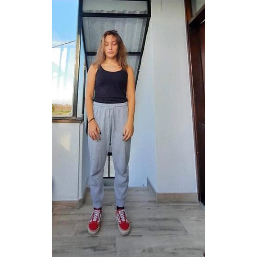

In [ ]:
template_image_src = cv.imread(template_path)
# src_tepml_width, src_templ_height, _ = template_image_src.shape 
template_image = cv.resize(template_image_src, (width, height))
cv2_imshow(template_image)

In [ ]:
# može se koristiti kasnije za crtanje ključnih točaka na izvornoj slici (prije promjene veličine)
# templ_ratio_width = src_tepml_width/width
# templ_ratio_height = src_templ_height/height

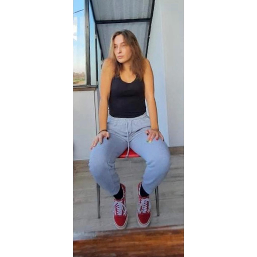

In [ ]:
target_image_src = cv.imread(target_path)
#src_tar_width, src_tar_height, _ = target_image_src.shape 
target_image = cv.resize(target_image_src, (width, height))
cv2_imshow(target_image)

In [ ]:
# tar_ratio_width = src_tar_width/width
# tar_ratio_height = src_tar_height/height

In [ ]:
#dodajte novu dimenziju koja odgovara unosu modela
template_input = np.expand_dims(template_image.copy(), axis=0)
target_input = np.expand_dims(target_image.copy(), axis=0)

U našem slučaju, model zahtijeva da ulazne slike imaju float vrijednosti koje također možemo normalizirati tako da budu u rasponu od 0 do 1 oduzimajući zadanu srednju vrijednost i dijeleći zadanu standardnu devijaciju. -->

In [ ]:
# provjeravanje vrste ulaznog tenzora
floating_model = input_details[0]['dtype'] == np.float32

In [ ]:
# Float modeli nude najbolju točnost, ali idu na štetu veličine modela
# i izvedbe. GPU ubrzanje zahtijeva upotrebu float modela.

# Dobivamo ulazne vrijednosti u rasponu od 0 do 1

In [ ]:
if floating_model:
  template_input = (np.float32(template_input) - 127.5) / 127.5
  target_input = (np.float32(target_input) - 127.5) / 127.5

ovo dalje su primarne radnje koje trebamo izvršiti da bismo pokrenuli ovaj TensorFlow lite model -->

In [ ]:
# Obrada slike predloška
# Postavlja vrijednost ulaznog tenzora
interpreter.set_tensor(input_details[0]['index'], template_input)
# Pokretanje računanja
interpreter.invoke()
# Izvlačenje izlaznih podataka iz tumača tj. interpretera
template_output_data = interpreter.get_tensor(output_details[0]['index'])
template_offset_data = interpreter.get_tensor(output_details[1]['index'])
# Riješavanje viška dimenzija
template_heatmaps = np.squeeze(template_output_data)
template_offsets = np.squeeze(template_offset_data)
print("template_heatmaps' shape:", template_heatmaps.shape)
print("template_offsets' shape:", template_offsets.shape)

template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)


In [ ]:
# Obradite ciljanu sliku. Iste naredbe
interpreter.set_tensor(input_details[0]['index'], target_input)
interpreter.invoke()
target_output_data = interpreter.get_tensor(output_details[0]['index'])
target_offset_data = interpreter.get_tensor(output_details[1]['index'])
target_heatmaps = np.squeeze(target_output_data)
target_offsets = np.squeeze(target_offset_data)

In [ ]:
# The output consist of 2 parts:
# - heatmaps (9,9,17) - corresponds to the probability of appearance of 
# each keypoint in the particular part of the image (9,9)(without applying sigmoid 
# function). Is used to locate the approximate position of the joint
# - offset vectors (9,9,34) is called offset vectors. Is used for more exact
#  calculation of the keypoint's position. First 17 of the third dimension correspond
# to the x coordinates and the second 17 of them correspond to the y coordinates

**Raščlanjivanje rezultata PoseNeta**

Izlaz se sastoji od 2 dijela:
Heatmaps (9,9,17) - odgovaraju vjerojatnosti pojave svake ključne točke u određenom dijelu slike (9,9) (bez primjene sigmoidne funkcije). Koriste se za lociranje približnog položaja zglobova.
Pomaknuti vektori (9,9,34) - oni se koriste za točniji izračun položaja ključne točke. Prvih 17 treće dimenzije odgovaraju x koordinatama, a njih 17 odgovara y koordinatama

In [ ]:
def parse_output(heatmap_data,offset_data, threshold):

  '''
  heatmap_data - toplinske mape za sliku. Trodimenzionalni niz
    offset_data - offset vektori za sliku. Trodimenzionalni niz
    prag - prag vjerojatnosti za ključne točke. Skalarna vrijednost
  Izlaz:
    niz s koordinatama ključnih točaka i zastavica za one koji imaju
    malu vjerojatnost
  '''

  joint_num = heatmap_data.shape[-1]
  pose_kps = np.zeros((joint_num,3), np.uint32)

  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
      max_prob = np.max(joint_heatmap)

      if max_prob > threshold:
        if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
          pose_kps[i,2] = 1

  return pose_kps


PSEUDOKOD ::: 

 **def parse_output (heatmap_data, offset_data, prag):**

   ///za svaku ključnu točku u heatmap_data:

    1. pronađite indekse maksimalnih vrijednosti u mreži 9x9
    2. izračunajte položaj ključne točke na slici
    3. podesite položaj s offset_data
    4. dobiti maksimalnu vjerojatnost
 
    ako je najveća vjerojatnost> prag:
      ako je položaj unutar oblika slike veličine:
        postavite zastavicu za vizualizaciju na True


In [ ]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
      if kps[i,2]:
        if isinstance(ratio, tuple):
          cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
          continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),-1)
    return show_img

Dodali smo zastavicu u svaku ključnu točku kako bismo mogli filtrirati one u koje model nije siguran i one za koje predviđa da su izvan slike.

Nakon toga na slici možemo nacrtati svaku ključnu točku kako bismo vizualizirali rezultat. Evo slika koje sadrže predložak i ciljne poze koje ćemo "matchati" :

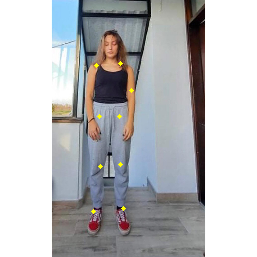

In [ ]:
template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
template_show = np.array(template_show*255,np.uint8)
template_kps = parse_output(template_heatmaps,template_offsets,0.3)
cv2_imshow(draw_kps(template_show.copy(),template_kps))

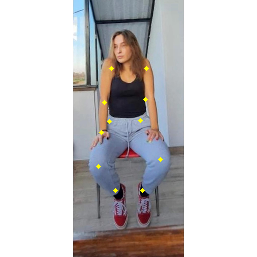

In [ ]:
target_show = np.squeeze((target_input.copy()*127.5+127.5)/255.0)
target_show = np.array(target_show*255,np.uint8)
target_kps = parse_output(target_heatmaps,target_offsets,0.3)
cv2_imshow(draw_kps(target_show.copy(),target_kps))

### Matching by angles and proportions

#### Set template values

In [ ]:
# Podudaranje indeksa ključnih točaka u izlazu PoseNet-a
# 0. Lijevo rame do desnog ramena (5-6)
# 1. Lijevo rame do lijevog lakta (5-7)
# 2. Desno rame do desnog lakta (6-8)
# 3. Lijevi lakat do lijevog zapešća (7-9)
# 4. Desni lakat do desnog zapešća (8-10)
# 5. Lijevi kuk do desnog kuka (11-12)
# 6. Lijevo rame do lijevog kuka (5-11)
# 7. Desno rame do desnog kuka (6-12)
# 8. Lijevi kuk do lijevog koljena (11-13)
# 9. Desni kuk do desnog koljena (12-14)
# 10. Lijevo koljeno do lijevog gležnja (13-15)
# 11. Desno koljeno do desnog gležnja (14-16)

In [ ]:
parts_to_compare = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]

**Način usporedbe položaja različitih dijelova tijela i njihovih međusobnih odnosa na slici**

Ideja ovog pristupa je usporediti kut između svakog dijela tijela i x osi za obje slike, kao i izračunati proporcije između dijelova tijela za svaku sliku i usporediti ih kako bi pokrili slučajeve kada se, na primjer, ruke kreću paralelno sa smjerom pogleda kamere tako da se kut ne mijenja.
Prvo izračunajmo ove vrijednosti kuta i veličine za svaki dio tijela.


In [ ]:
def angle_length(p1, p2):

  '''
  Ulazi:
    p1 - ​​koordinate točke 1. liste
    p2 - koordinate točke 2. liste
  Izlaz:
    Tuple koji sadrži vrijednost kuta između linije koju čine dvije ulazne točke,
     os x kao prvi element i duljina ove linije kao drugi
    element
  '''

  angle = math.atan2(- int(p2[0]) + int(p1[0]), int(p2[1]) - int(p1[1])) * 180.0 / np.pi
  length = math.hypot(int(p2[1]) - int(p1[1]), - int(p2[0]) + int(p1[0]))
  
  return round(angle), round(length)

**PSEUDOKOD** ::: 

def podudaranje (template_kp, target_kp, angle_deviation = 20, size_deviation = 1):
  1. postavite anchor size za izračun proporcija - udaljenost između ramena

  Za svaki dio tijela za koji smo izračunali kut i veličinu:
    1. Izračunaj razliku između kutova
    2. Izračunajte omjer između dijela tijela i anchora za template_pose (proporcija)
    3. Izračunajte omjer između dijela tijela i anchora za target_pose (proporcija)
    
    ako je razlika između kutova> prag odstupanja_kut:
      dio tijela je odstupan
    elif razlika između proporcija> prag odstupanja od veličine_:
      dio tijela je odstupan
  vratite popis dijelova tijela koji odstupaju


In [ ]:
template_values = []
for part in parts_to_compare:
  template_values.append(angle_length(template_kps[part[0]][:2], template_kps[part[1]][:2]))
template_values

[(5, 24),
 (-107, 28),
 (-68, 29),
 (-71, 18),
 (-90, 29),
 (0, 20),
 (-87, 51),
 (-91, 53),
 (-66, 52),
 (-111, 53),
 (-86, 44),
 (-99, 46)]

In [ ]:
target_values = []
for part in parts_to_compare:
  target_values.append(angle_length(target_kps[part[0]][:2], target_kps[part[1]][:2]))
target_values

[(180, 35),
 (-92, 31),
 (-102, 35),
 (-80, 29),
 (-96, 30),
 (-178, 31),
 (-97, 52),
 (-92, 53),
 (-63, 44),
 (-104, 46),
 (-120, 36),
 (-55, 29)]

In [ ]:
#with open('template.pkl', 'wb') as f:
#     pickle.dump(template, f)

In [ ]:
# with open('template.pkl', 'rb') as f:
#   template = pickle.load(f)

#### Matching

In [ ]:
def matching(template_kp, target_kp, angle_deviation=30, size_deviation=1):

  '''
      Ulazi:
      1. template_kp - popis korijena (za sliku predloška) sadrži kutove
      između pojedinih dijelova tijela i osi x kao prvih elemenata i njegovih veličina
      (udaljenosti između odgovarajućih točaka kao drugih elemenata)
      2. target_kp - isto i za ciljanu sliku
      3. odstupanje_kut - prihvatljiva kutna razlika između odgovarajućih
      dijelova tijela na slikama
      4. odstupanje od veličine - razlika u prihvatljivim omjerima između slika
    Izlaz:
      Popis dijelova tijela koji imaju odstupanja
  '''

  devs = []

  #postavite veličinu sidra (anchora) za izračun proporcija - udaljenost između ramena
  templ_anchor = template_kp[0][1]
  targ_anchor = target_kp[0][1]

  #za svaki dio tijela za koji smo izračunali kut i veličinu
  for i in range(len(template_kp)):

    angles = (template_kp[i][0], target_kp[i][0])
    diff_angle = max(angles) - min(angles)

    templ_size = (template_kp[i][1],templ_anchor)
    templ_size = abs(min(templ_size) / max(templ_size))

    tar_size = (target_kp[i][1], targ_anchor)
    tar_size = abs(min(tar_size) / max(tar_size))

    if diff_angle > angle_deviation:
      devs.append(i)
      print("{0} has different angle".format(i))

    elif max(tar_size,templ_size) - min(tar_size,templ_size) > size_deviation:
      devs.append(i)
      print("{0} has different size".format(i))

  return devs

In [ ]:
deviations = matching(template_values, target_values)
deviations

0 has different angle
2 has different angle
5 has different angle
10 has different angle
11 has different angle


[0, 2, 5, 10, 11]

#### Draw deviations

In [ ]:
def draw_deviations(img, keypoints, pairs, deviations):

  for i, pair in enumerate(pairs):

    if i in deviations:
      color = (0,0,255)
    else:
      color = (0,255,0)
      
    cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

In [ ]:
draw_deviations(target_show, target_kps, parts_to_compare, deviations)

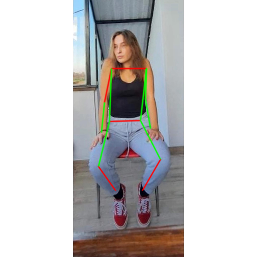

In [ ]:
cv2_imshow(target_show)

In [ ]:
#cv.imwrite('devs.jpg', target_show)

True

### Matching by finding the target pose in the image

#### Set a target pattern

In [ ]:
#Matrica nula s oblikom slike predloška
template_pose = np.zeros_like(template_show)

In [ ]:
# connect some of the points 
def join_point(img, kps):

  body_parts = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),
                      (6,12),(11,13),(12,14),(13,15),(14,16)]

  for part in body_parts:
    cv.line(img, (kps[part[0]][1], kps[part[0]][0]), (kps[part[1]][1], kps[part[1]][0]), 
            color=(255,255,255), lineType=cv.LINE_AA, thickness=3)


In [ ]:
# nacrtajte kostur poze predloška na praznu sliku
join_point(template_pose, template_kps[:, :2])

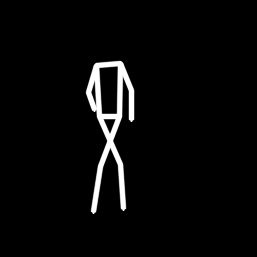

In [ ]:
cv2_imshow(template_pose)

In [ ]:
# postavite nove dimenzije slike kako biste smanjili veličinu
buffer = 5 # veličina područja oko poze
top_left_y = min(template_kps[5:, 0]) - buffer
top_left_x = min(template_kps[5:, 1]) - buffer
buttom_right_y = max(template_kps[5:, 0]) + buffer
buttom_right_x = max(template_kps[5:, 1]) + buffer

In [ ]:
#obrezivanje predloška poze s novim dimenzijama
template_pose = template_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

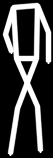

In [ ]:
cv2_imshow(template_pose)

In [ ]:
# spremite obrazac predloška
#cv.imwrite('template_pose.jpg', template_pose)

True

#### Find the pattern in the new image

In [ ]:
# Matricu nula s oblikom ciljne slike
target_pose = np.zeros_like(target_show)

In [ ]:
# nacrtajte kostur poze cilja na praznu sliku
join_point(target_pose, target_kps[:, :2])

In [ ]:
# postavite nove dimenzije slike kako biste smanjili veličinu
buffer = 5 # veličina područja oko poze
top_left_y = min(target_kps[5:, 0]) - buffer
top_left_x = min(target_kps[5:, 1]) - buffer
buttom_right_y = max(target_kps[5:, 0]) + buffer
buttom_right_x = max(target_kps[5:, 1]) + buffer

In [ ]:
target_pose = target_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

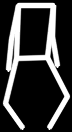

In [ ]:
cv2_imshow(target_pose)

In [ ]:
#cv.imwrite('target_pose.jpg', target_pose)

True

In [ ]:
template_pose = cv.cvtColor(template_pose, cv.COLOR_BGR2GRAY)
target_pose = cv.cvtColor(target_pose, cv.COLOR_BGR2GRAY)

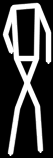

In [ ]:
cv2_imshow(template_pose)

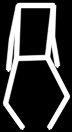

In [ ]:

cv2_imshow(target_pose)

In [ ]:
# što je veći prag točnije se poza podudara
threshold = 0.1

w, h = target_pose.shape[::-1]
res = cv.matchTemplate(target_pose,template_pose, cv.TM_CCOEFF_NORMED)
score = res.max()

print("score:", score)

if score >= threshold:
  print("Match")
else:
  print("Don't match")

error: ignored

### Draw grid

In [ ]:
def draw_grid(img, grid_size=9, heatmap=None, part=1):

    color = (0,255,255)

    small_size = min(img.shape[0], img.shape[1])
    cell_size = small_size // grid_size
    res = int(small_size % grid_size)

    x = res // 2
    y = res // 2

    while x < img.shape[1]:
      cv.line(img, (x, 0), (x, img.shape[0]), color=color, lineType=cv.LINE_AA, thickness=1)
      x += cell_size

    while y < img.shape[0]:
      cv.line(img, (0, y), (img.shape[1], y), color=color, lineType=cv.LINE_AA, thickness=1)
      y += cell_size

    center_x = res//2
    center_y = res//2 + cell_size//2

    cv.putText(image,str(round(heatmap[0,0,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)

    for row_idx, row in enumerate(heatmap[...,part]):

      for col_idx, column in enumerate(row):
        cv.putText(image,str(round(heatmap[col_idx,row_idx,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)
        center_y += cell_size
        
      center_x += cell_size
      center_y = res//2 + cell_size//2

In [ ]:
image = cv.imread('image.jpg')
image = cv.resize(image, (257, 257)) 

In [ ]:
draw_grid(image, 9, template_heatmaps)

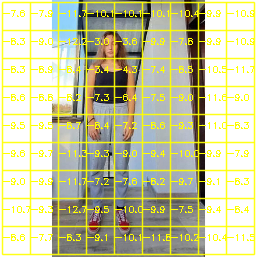

In [ ]:
cv2_imshow(image)

In [ ]:
#cv.imwrite('image.jpg', image)

True